In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score
from scipy.stats import uniform
import random
np.random.seed(32)
random.seed(32)

# Hyperparameters tuning using Bayesian Optimization with the skopt library

As you are going to see, the project for this first part of the course will be to use Bayesian Optimization to tune the hyperparameters of a Random forest classifier. To do that you are going to use a library that is more optimized compare to the code from scratch that we have written before.

In this exercise you are going to use Bayesian Optimization to select the best hyperparameters of a random forest trained on part of the MNIST dataset. You are going also to compare it with respect to a random search on the hyperparameter space.


In [4]:
def load_MNIST():
    '''
    Function to load the MNIST training and test set with corresponding labels.

    :return: training_examples, training_labels, test_examples, test_labels
    '''

    # we want to flat the examples

    training_set = datasets.MNIST(root='./data', train=True, download=True, transform= None)
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform= None)

    Xtrain = training_set.data.numpy().reshape(-1,28*28)
    Xtest = test_set.data.numpy().reshape(-1,28*28)

    ytrain = training_set.targets.numpy()
    ytest = test_set.targets.numpy()

    return Xtrain, ytrain, Xtest, ytest

In [5]:
## since training a random forest on the entire dataset takes some time
## we can consider only few labels, like 3, 5, 8 and 9

## we can load the training set and test set
Xtrain, ytrain, Xtest, ytest = load_MNIST()

# Limit the number of training examples mainly just for speed
Xtrain=Xtrain[:1000]
ytrain=ytrain[:1000]


# print some information
print('Information about the new datasets')
print('Training set shape:', Xtrain.shape)
print('Test set shape', Xtest.shape)

Information about the new datasets
Training set shape: (1000, 784)
Test set shape (10000, 784)


## Random forest

As you have seen in your Machine Learning course, there are a lot of hyperparameters to choose before training a Random Forest. If you look at the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) you can notice all the paramters. For this exercise we will focus only on the following four hyperparameters:

1. **n_estimators**: the number of decision trees that are in the forest;
2. **criterion**: the criterion to evaluate the split. We should decide between *Gini impurity* (`gini`) and *information gain* (`entropy`);
3. **max_depth**: Maximum depth of the trees. If None, the tree expands until we have a element in all the leaves or  until all leaves contain less than min_samples_split samples.
4. **max_features**: The number of features to consider when looking for the best split. We have to choose among `'sqrt'` where we consider `sqrt(n_features)`, `'log2'` where we consider `log2(n_features)` or None which will just use all features.

Remember that when we are using Random Forest we can avoid running the cross-validation to get the validation error as approximation of the test error, but instead we can use the *out of bag* error to get an approximation of the test error we are going to get when we consider unseen example. 

In [6]:
model = RandomForestClassifier(oob_score=True,n_estimators=10,criterion='gini',max_depth=10,max_features='sqrt')
model.fit(Xtrain, ytrain)
print('Default model out of bag error', model.oob_score_)
print('Default model test accuracy', model.score(Xtest, ytest))

Default model out of bag error 0.725
Default model test accuracy 0.7841


/home/mathias/miniconda3/envs/02463/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


### Random search 

A possible way to find the best hyperparameters is to use random search over the parameter space. To perform this operation we can use `RandomizedSearchCV`. You can look at the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). However, since we do not need cross-validation for Random Forests, we can use `ParameterSampler` to sample random parameters from our parameter space. Look at the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html#sklearn.model_selection.ParameterSampler) To be able to use this method you should first define a dictionary of the hyperparameters you want to optimize, in this case the four we mentioned above, and then decide a way to evaluate the model and how many folds for the cross-validation. The dictionary is of the form:

```python
params = {"name_params": uniform(0, 1), # if it is continuous between 0 and 1
           "name_params2": range(1,50), # if it is discrete but integer
           "name_params3": ['name1', 'name2']} # if it is discrete but string`
```

<font color='lightblue'> Tasks:

1. <font color='lightblue'> Create the dictionary of the hyperparameters, we recommend keeping the value of the number of trees up to 150 otherwise it takes a very long time and the max_depth up to 100. After that, you can use the dictionary to create a random hyperparameter using `ParameterSampler`. The `ParameterSampler` call is already provided.

2. <font color='lightblue'> Using the parameters returned by the `ParameterSampler` you should fit a random forest, and for each iteration you should store the best value of the `model.oob_score_` you get. **HINT:** You can access the hyperparameters value by the name you used in the defined dictionary. (The whole process should take up to a few minutes)

In [7]:
import time
# hyperparams dictionary 
domain = {"n_estimators": range(1, 150),
          "criterion": ["gini", "entropy"],
          "max_depth": range(1, 100),
          "max_features": ["sqrt", "log2", None]}

# create the ParameterSampler
param_list = list(ParameterSampler(domain, n_iter=20, random_state=32))
print('Param list')
print(param_list)

## now we can train the random forest using these parameters tuple, and for
## each iteration we store the best value of the oob

current_best_oob = 0
iteration_best_oob = 0 
max_oob_per_iteration = []
i = 0
for params in param_list:
    print(i)
    print(params)
    
    #define model here
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'], 
        criterion=params['criterion'], 
        max_depth=params['max_depth'],
        max_features=params['max_features'],
        oob_score=True, n_jobs=-1)
    
    start = time.time()
    #train the model
    model.fit(Xtrain, ytrain)

    end = time.time()
    # extract oob_score and update current_best_oob if better that the current best
    if model.oob_score_ > current_best_oob:
        current_best_oob = model.oob_score_
        iteration_best_oob = i
    
    max_oob_per_iteration.append(current_best_oob)
    i += 1
    print(f'It took {end - start} seconds')

print('Best oob score:', current_best_oob, 'at iteration', iteration_best_oob)
    

Param list
[{'n_estimators': 91, 'max_features': 'log2', 'max_depth': 25, 'criterion': 'gini'}, {'n_estimators': 116, 'max_features': None, 'max_depth': 69, 'criterion': 'entropy'}, {'n_estimators': 89, 'max_features': None, 'max_depth': 36, 'criterion': 'entropy'}, {'n_estimators': 2, 'max_features': None, 'max_depth': 46, 'criterion': 'gini'}, {'n_estimators': 95, 'max_features': 'log2', 'max_depth': 56, 'criterion': 'gini'}, {'n_estimators': 134, 'max_features': 'sqrt', 'max_depth': 92, 'criterion': 'entropy'}, {'n_estimators': 119, 'max_features': 'sqrt', 'max_depth': 22, 'criterion': 'entropy'}, {'n_estimators': 101, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}, {'n_estimators': 144, 'max_features': 'log2', 'max_depth': 92, 'criterion': 'gini'}, {'n_estimators': 47, 'max_features': None, 'max_depth': 85, 'criterion': 'gini'}, {'n_estimators': 89, 'max_features': 'sqrt', 'max_depth': 22, 'criterion': 'gini'}, {'n_estimators': 66, 'max_features': None, 'max_depth

/home/mathias/miniconda3/envs/02463/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


It took 0.42041993141174316 seconds
5
{'n_estimators': 134, 'max_features': 'sqrt', 'max_depth': 92, 'criterion': 'entropy'}
It took 0.6658666133880615 seconds
6
{'n_estimators': 119, 'max_features': 'sqrt', 'max_depth': 22, 'criterion': 'entropy'}
It took 0.4818549156188965 seconds
7
{'n_estimators': 101, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}
It took 0.3403925895690918 seconds
8
{'n_estimators': 144, 'max_features': 'log2', 'max_depth': 92, 'criterion': 'gini'}
It took 0.4448063373565674 seconds
9
{'n_estimators': 47, 'max_features': None, 'max_depth': 85, 'criterion': 'gini'}
It took 0.6731634140014648 seconds
10
{'n_estimators': 89, 'max_features': 'sqrt', 'max_depth': 22, 'criterion': 'gini'}
It took 0.2882986068725586 seconds
11
{'n_estimators': 66, 'max_features': None, 'max_depth': 72, 'criterion': 'entropy'}
It took 1.181687831878662 seconds
12
{'n_estimators': 96, 'max_features': None, 'max_depth': 40, 'criterion': 'gini'}
It took 1.0909700393676758 

### Bayesian Optimization

The procedure we are interested in, instead, is Bayesian Optimization. Here we will use the scikit-optimize (skopt) package and the gp_minimize function.
For this we will meed to define an objective function and define the bounds to optimize within.
<br>Unfortunately, skopt does not allow None to be passed as a categorical option is is actually used here, therefore you have to handle the None option for the max_features by converting the input from a string to None inside the objective function.
<br>skopt will use one-out-of-k encoding for categorical variables with more than 2 options

In case of random forest, you should return the `oob_score` and not the validation score. If you are going to use other models you should consider the validation set, instead.

You should create an Bayesian Optimization instancer using the following function `skopt.gp_minimize`, see the complete description [here](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html).

At the end of the optimization, you can access the array of the best parameters by `opt.x`. You can also collect the best `oob_score` per iteration using 
`np.maximum.accumulate(-opt.func_vals).ravel()`.

Investigate the documentation for gp_minimize, use the EI acqusition function and set the xi parameter to 0.1 and the noise to 0.01**2.


<font color='lightblue'> Tasks:

1. <font color='lightblue'>You should define an objective function which can be called and returns the negative oob_score.

2. <font color='lightblue'>In the same plot, show the best `oob_score` per iteration you obtain using the random search and the bayesian optimization. What do you see?

    

In [8]:
import skopt
from skopt import gp_minimize

#start at same initial point
x0=[param_list[0]['n_estimators'],param_list[0]['max_depth'],param_list[0]['max_features'],param_list[0]['criterion']]
if x0[2] is None:
    x0[2] = 'None'


y0 = -max_oob_per_iteration[0]


## define the domain of the considered parameters
n_estimators = (1,150)
max_depth=(1,100)
max_features = ('log2', 'sqrt', 'None')
criterion = ('gini', 'entropy')


## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
global i
i = 1
def objective_function(x): 
    if x[2]=='None':
        maxf = None
    else:
        maxf = x[2]
    
    #create the model
    model = RandomForestClassifier(
        n_estimators=x[0], 
        criterion=x[3], 
        max_depth=x[1], 
        max_features=maxf, 
        oob_score=True, n_jobs=-1)
    
    # fit the model
    model.fit(Xtrain, ytrain)
    
    global i
    i += 1
    print(i)
    print(x)
    print(model.oob_score_)
    
    return - model.oob_score_

np.int = int #numpy np.int deprecation workaround
opt = gp_minimize(
    objective_function, 
    [n_estimators, max_depth, max_features, criterion], 
    x0=[x0,], 
    y0=[y0,], 
    acq_func='EI', 
    n_calls=20-1, 
    n_initial_points=0,
    xi=0.1,
    noise=0.01**2
)

/home/mathias/miniconda3/envs/02463/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


2
[np.int64(1), np.int64(100), np.str_('sqrt'), np.str_('entropy')]
0.27
3
[np.int64(100), np.int64(23), np.str_('log2'), np.str_('gini')]
0.868
4
[np.int64(150), np.int64(1), np.str_('sqrt'), np.str_('gini')]
0.481
5
[np.int64(150), np.int64(1), np.str_('log2'), np.str_('entropy')]
0.467
6
[np.int64(136), np.int64(50), np.str_('sqrt'), np.str_('gini')]
0.893


/home/mathias/miniconda3/envs/02463/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


7
[np.int64(4), np.int64(64), np.str_('None'), np.str_('entropy')]
0.571
8
[np.int64(129), np.int64(70), np.str_('sqrt'), np.str_('gini')]
0.869
9
[np.int64(1), np.int64(1), np.str_('sqrt'), np.str_('gini')]
0.136


/home/mathias/miniconda3/envs/02463/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10
[np.int64(137), np.int64(59), np.str_('None'), np.str_('gini')]
0.87
11
[np.int64(150), np.int64(1), np.str_('None'), np.str_('entropy')]
0.37
12
[np.int64(105), np.int64(50), np.str_('log2'), np.str_('gini')]
0.879
13
[np.int64(1), np.int64(100), np.str_('log2'), np.str_('gini')]
0.274


/home/mathias/miniconda3/envs/02463/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


14
[np.int64(150), np.int64(31), np.str_('sqrt'), np.str_('gini')]
0.891
15
[np.int64(150), np.int64(100), np.str_('log2'), np.str_('gini')]
0.888
16
[np.int64(150), np.int64(87), np.str_('None'), np.str_('gini')]
0.87
17
[np.int64(112), np.int64(100), np.str_('None'), np.str_('gini')]
0.88
18
[np.int64(112), np.int64(37), np.str_('sqrt'), np.str_('gini')]
0.88
19
[np.int64(150), np.int64(100), np.str_('None'), np.str_('entropy')]
0.866
20
[np.int64(78), np.int64(73), np.str_('None'), np.str_('gini')]
0.86


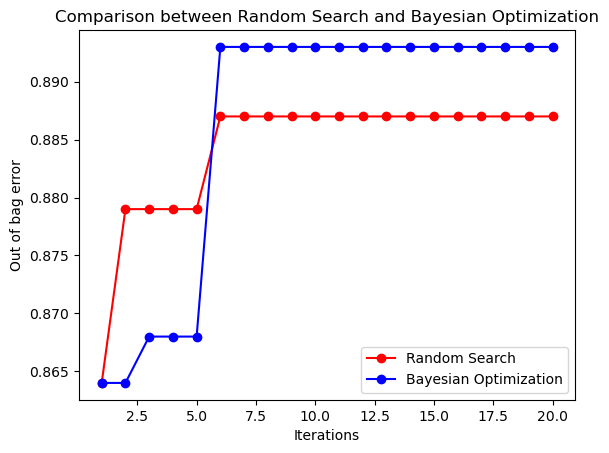

In [9]:
## comparison between random search and bayesian optimization
## we can plot the maximum oob per iteration of the sequence

# collect the maximum each iteration of BO
y_bo = np.maximum.accumulate(-opt.func_vals).ravel()

# define iteration number
xs = np.arange(1,21,1)

plt.plot(xs, max_oob_per_iteration, 'o-', color = 'red', label='Random Search')
plt.plot(xs, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Out of bag error')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.show()

# [OPTIONAL] Investigate the acquisition function
HINTS:<br> Important: note that skopt normalizes the input space between 0 and 1, hence you have to convert the values to evaluate to this interval<br>
As the function is of more than 2 dimensional in this case it is not trivial to plot it, therefore keep the categorical variables fixed at some value (for example at zero).<br>Note that skopt actually just uses a normal GP even for the categorical variables in this case, try to thihnk about why this is probably not a good approach.<br> Then you can evaluate the acquisition function on a grid for the remaining two variables using np.meshgrid.
<br>
<font color='lightblue'>
1. <font color='lightblue'> Investigate the dimensionality of the GP (look at the model subclass), how many variables are there?<br>
2. <font color='lightblue'> Plot the surrogate function and its standard deviation, you can use the models predict function <br>
3. <font color='lightblue'> Take a look at the acqusition function.  The acquisition function can be evaluated using <a href=https://scikit-optimize.github.io/stable/modules/generated/skopt.acquisition.gaussian_ei.html#skopt.acquisition.gaussian_ei>skopt.acquisition.gaussian_ei</a>)

In [10]:
# the line below shows how to encode 'log2' as max_features
print(opt.space[2][1].transform(['log2']))
# the line below shows how to encode the criterion 'gini'
print(opt.space[3][1].transform(['gini']))

n_estimators = (1,151) #add 1 to include limit
max_depth=(1,101) #add 1 to include the limit


#We start by taking a look a the model subclass of our Bayesian optimization object
print(opt)
#get the last model
model = opt.models[-1]
#To get a plot of the acquisition function we use the model's predict function
#first we define a sensible grid for the first to parameters
#indexing='ij' ensures that x/y axes are not flipped (which is default):
#note that the acqusition function can actually take any value not only integers as it lives in the GP space
#and it is quite fast to evaluate even for many points

# this code will create an array of points to evaluate the function in the normalized space
# the result should be a 6xNpoints array where the first two rows are the n_estimators and max_depth
# the last 4 column are for the categorical variables, to encode 'log2' the first column is set to 1
# the last column will indicate 'gini' as the first option for the criterion
pgrid = np.array(np.meshgrid(np.arange(*n_estimators), np.arange(*max_depth),indexing='ij'))
pgrid_norm = np.array([opt.space[i][1].transform(x) for i,x in enumerate(pgrid.reshape(2,-1))])
extra_dims = np.zeros((4,pgrid_norm.shape[1]))
extra_dims[0,:] = 1
pgrid_norm = np.concatenate((pgrid_norm,extra_dims),axis=0)
print(pgrid_norm.shape)


[[1 0 0]]
[[0]]
          fun: -0.893
            x: [np.int64(136), np.int64(50), np.str_('sqrt'), np.str_('gini')]
    func_vals: [-8.640e-01 -2.700e-01 ... -8.660e-01 -8.600e-01]
      x_iters: [[91, 25, 'log2', 'gini'], [np.int64(1), np.int64(100), np.str_('sqrt'), np.str_('entropy')], [np.int64(100), np.int64(23), np.str_('log2'), np.str_('gini')], [np.int64(150), np.int64(1), np.str_('sqrt'), np.str_('gini')], [np.int64(150), np.int64(1), np.str_('log2'), np.str_('entropy')], [np.int64(136), np.int64(50), np.str_('sqrt'), np.str_('gini')], [np.int64(4), np.int64(64), np.str_('None'), np.str_('entropy')], [np.int64(129), np.int64(70), np.str_('sqrt'), np.str_('gini')], [np.int64(1), np.int64(1), np.str_('sqrt'), np.str_('gini')], [np.int64(137), np.int64(59), np.str_('None'), np.str_('gini')], [np.int64(150), np.int64(1), np.str_('None'), np.str_('entropy')], [np.int64(105), np.int64(50), np.str_('log2'), np.str_('gini')], [np.int64(1), np.int64(100), np.str_('log2'), np.str_('gin

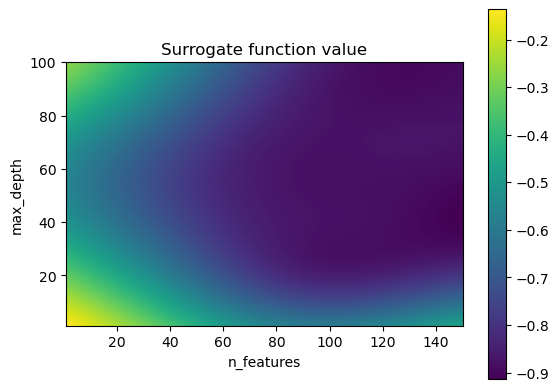

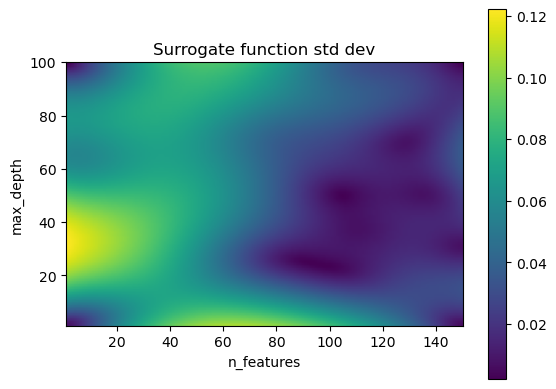

In [11]:
# write code to evaluate the surrogate function and it's standard deviation in the normalized grid
# then reshape into image and plot using the plt.imshow function (already provided)

ye_img, ye_std_img = model.predict(pgrid_norm.T, return_std=True)
ye_img = ye_img.reshape(pgrid[0].shape)
ye_std_img = ye_std_img.reshape(pgrid[0].shape)


plt.figure()
plt.imshow(ye_img.T, origin='lower',extent=[pgrid[0][0][0],pgrid[0][-1][0],pgrid[0][0][0],pgrid[1][0][-1]])
plt.colorbar()
plt.xlabel('n_features')
plt.ylabel('max_depth')
plt.title('Surrogate function value')

plt.figure()
plt.imshow(ye_std_img.T, origin='lower',extent=[pgrid[0][0][0],pgrid[0][-1][0],pgrid[1][0][0],pgrid[1][0][-1]])
plt.colorbar()
plt.xlabel('n_features')
plt.ylabel('max_depth')
plt.title('Surrogate function std dev');

In [12]:
#evaluate the acqusition function using skopt.acquisition.gaussian_ei and plot it

plt.figure()
plt.imshow(acq_val_img.T, origin='lower',extent=[pgrid[0][0][0],pgrid[0][-1][0],pgrid[0][0][0],pgrid[1][0][-1]])
plt.colorbar()
plt.xlabel('n_features')
plt.ylabel('max_depth')
plt.title('Acquisition function');

NameError: name 'acq_val_img' is not defined

<Figure size 640x480 with 0 Axes>